In [1]:
#import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import folium
import matplotlib.pyplot as plt

In [2]:
# Read in shapefile
# Downloaded from https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip

shape_data = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip")

shape_data.head(3)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,39,071,01074048,0500000US39071,39071,Highland,06,1432479992,12194983,"POLYGON ((-83.86976 39.05553, -83.86568 39.247..."
1,06,003,01675840,0500000US06003,06003,Alpine,06,1912292630,12557304,"POLYGON ((-120.07248 38.50987, -120.07239 38.7..."
2,12,033,00295737,0500000US12033,12033,Escambia,06,1701544502,563927612,"POLYGON ((-87.62999 30.87766, -87.62946 30.880..."


In [3]:
# Filter to only counties in Illinois using StateFP column = 17 
shape_data = shape_data.loc[(shape_data['STATEFP'] == "17")]

shape_data.head(3)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
3,17,101,00424252,0500000US17101,17101,Lawrence,06,963936864,5077783,"POLYGON ((-87.91028 38.57493, -87.90811 38.850..."
22,17,093,00424248,0500000US17093,17093,Kendall,06,829468028,5136619,"POLYGON ((-88.60349 41.71358, -88.60193 41.719..."
57,17,139,01784885,0500000US17139,17139,Moultrie,06,870123798,22102741,"POLYGON ((-88.81271 39.74049, -88.75784 39.739..."


In [4]:
# Read in contract  csv file
contract_data = pd.read_csv("../IL_CEI/can-summer-2023/data/raw/contracts/illinois_bidbuy_contracts_as_of_20230614.csv")
# make the company name lower case
contract_data["Vendor"] = contract_data.Vendor.str.lower()
contract_data

,Contract / Blanket #,Bid Solicitation #,Description,Vendor,Type Code,Dollars Spent to Date,Organization,Status,Begin Date,End Date
0,CIB6354390,NaN,Prescription Drugs,"caremarkpcs health, l.l.c.",B,$0.00,CMS - Central Management Services,3PS - Sent,07/01/2015,06/30/2024
1,CIB5736630,NaN,ConnectYourCare - Flexible Spending,"connectyourcare, llc",A,$0.00,CMS - Central Management Services,3PS - Sent,07/01/2019,06/30/2023
2,23-563WCC-WCC56-P-39787,NaN,Sole Source- WCRI CompScope Reports 23,wcri,D,$0.00,WCC - Illinois Worker's Compensation Commission,3PS - Sent,08/15/2022,06/30/2023
3,23-563WCC-WCC56-P-38456,NaN,EDI Hosting and Maintenance FY 23,"ebix, inc.",C,$0.00,WCC - Illinois Worker's Compensation Commission,3PS - Sent,07/01/2022,06/30/2023
4,23-551HDA-LEGAL-P-39047,NaN,Foley & Lardner Bond Counsel (Exempt),foley & lardner llp,Z,$0.00,HDA - Housing Development Authority,3PS - Sent,07/07/2022,07/06/2024
...,...,...,...,...,...,...,...,...,...,...
1371,17-416CMS-BOSS4-P-99,NaN,JPMC PAPER AND ENVELOPES SMALL QTYS,midland paper,A,"$4,502,328.93",CMS - Central Management Services,3PS - Sent,03/06/2017,07/31/2023
1372,17-416CMS-BOSS4-P-39,NaN,MC Fleet Fuel Card Services,wex bank,B,"$279,800.00",CMS - Central Management Services,3PS - Sent,07/01/2016,06/30/2025
1373,14Z0879001,NaN,Pharmacy Benefits Management (PBMS),"change healthcare pharmacy solutions, inc.",B,$0.00,HFS - Healthcare and Family Services,3PS - Sent,03/17/2014,03/16/2024
1374,13Z1819001,NaN,HFS MMIS Upgrade Project Expert Services,cognizant technology solutions us corp,B,$0.00,HFS - Healthcare and Family Services,3PS - Sent,06/20/2013,06/19/2023


In [5]:
# Load vendor data so as to get the zip codes
vendor_data = pd.read_csv("../IL_CEI/can-summer-2023/data/raw/vendors/illinois_state_vendor_registry_as_of_20230614.csv", encoding='cp1252', dtype=str)
vendor_data = vendor_data[['Company Name', 'DBA Name', 'Contact Person', 'Address', 'City',
       'State', 'Zip', 'Phone', 'Fax', 'Email']]  
vendor_data = vendor_data.dropna(subset='Zip')
vendor_data['Zip'] = vendor_data['Zip'].str.replace('\t', '')
vendor_data

# make the company name lower case
vendor_data["Company Name"] = vendor_data["Company Name"].str.lower()
vendor_data

,Company Name,DBA Name,Contact Person,Address,City,State,Zip,Phone,Fax,Email
0,"'d' construction, inc.",NaN,Lori Pierard,1488 SOUTH BROADWAY,COAL CITY,IL,60416,815-634-2555,NaN,k.liebermann@dconstruction.com
1,#1 professional cleaning services,NaN,Howard Glasper,2205 Mayfair,Westchester,IL,60154,708-574-5547,000-000-0000,1pcs888@gmail.com
2,"*prado & renteria cpas, prof. corp.",Corp.,Guadalupe Soto,1837 South Michigan Avenue,Chicago,IL,60616,312-788-1450,312-567-1360,rfear@pradorenteria.com
3,"@veterans construction group, llc.",NaN,Michael Palaguachi,2608 W 25th St,Chicago,IL,60608,773-951-5755,NaN,procurement@vets-construction.com
4,0x global llc,NaN,Adrian Zaharia,"6177 N Lincoln Ave, Suite 306",Chicago,IL,60659,312-473-7414,NaN,estimating@0xglobal.co
...,...,...,...,...,...,...,...,...,...,...
3537,zirin consulting llc,NaN,Joshua Zirin,926 Monticello Drive,Naperville,IL,60563,630-631-9692,NaN,josh@zirinconsulting.com
3538,zoi incorporated,ZOI Global Consulting,Susanna Alvarado,"998 Church St, Unit 405",Glenview,IL,60025,312-340-7060,NaN,susanna.alvarado@zoiinc.com
3539,"zonatherm products, inc.",NaN,Courtney Curtis,875 Busch Parkway,Buffalo Grove,IL,60089,847-541-1129,847-541-1750,ccurtis@zonatherm.com
3540,zuber lawler llp,NaN,Martin P Greene,"111 W Jackson Blvd, Suite 1700",Chicago,IL,60604,312-346-1100,213-596-5621,eletts@zuberlaw.com


In [6]:
# merge contract and vendor data

contract_data_pro = pd.merge(contract_data, vendor_data, left_on = 'Vendor', right_on = "Company Name", how = "inner")

contract_data_pro

,Contract / Blanket #,Bid Solicitation #,Description,Vendor,Type Code,Dollars Spent to Date,Organization,Status,Begin Date,End Date,Company Name,DBA Name,Contact Person,Address,City,State,Zip,Phone,Fax,Email
0,23-494DOT-DISTR-P-51168,NaN,Poly Liner - 931A,"energy culvert company, llc",C,$0.00,DOT - Transportation,3PS - Sent,05/17/2023,08/31/2023,"energy culvert company, llc",NaN,Charlie Kemp,"PO Box 640, Energy",Energy,IL,62933,618-942-7381,618-942-7834,nrgcmp@yahoo.com
1,23-493ISP-OPERA-P-44593,NaN,DCI-Analytic software and equipment -IFB-ah,"national tek services, inc.",A,"$417,038.00",ISP - Illinois State Police,3PS - Sent,12/20/2022,12/19/2027,"national tek services, inc.",NaN,Terry Benzel,POBox 6,Libertyville,IL,60048,847-850-1201,847-850-1204,sales@tekservinc.com
2,23-466MIL-LNCCH-P-43107,NaN,LCA-Desktop Computers-SE,"national tek services, inc.",C,$0.00,MIL - Military Affairs,3PS - Sent,10/25/2022,06/30/2023,"national tek services, inc.",NaN,Terry Benzel,POBox 6,Libertyville,IL,60048,847-850-1201,847-850-1204,sales@tekservinc.com
3,23-444DHS-MIS44-P-42160,NaN,23-OCAPS Project Mgmnt Software,"national tek services, inc.",C,$0.00,DHS - Human Services,3PS - Sent,11/01/2022,10/31/2025,"national tek services, inc.",NaN,Terry Benzel,POBox 6,Libertyville,IL,60048,847-850-1201,847-850-1204,sales@tekservinc.com
4,23-444DHS-MIS44-P-42158,NaN,23-IES ScanOptics Maint.,"national tek services, inc.",C,$0.00,DHS - Human Services,3PS - Sent,11/01/2022,10/31/2023,"national tek services, inc.",NaN,Terry Benzel,POBox 6,Libertyville,IL,60048,847-850-1201,847-850-1204,sales@tekservinc.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,17-448DOIT-APP44-P-168,NaN,JPMC DOIT - ITRP Terms and Conditions Only - I...,"io datasphere, inc.",A,$0.00,DoIT - Department of Innovation and Technology,3PS - Sent,11/14/2016,06/30/2026,"io datasphere, inc.",NaN,Susan Farmer,PO Box 1444,Warrenville,IL,60555,630-520-0260,630-381-1336,sfarmer@iodatasphere.com
402,17-448DOIT-APP44-P-164,NaN,JPMX DOIT - ITRP Terms and Conditions Only - G...,"gnc consulting, inc",A,$0.00,DoIT - Department of Innovation and Technology,3PS - Sent,11/14/2016,06/30/2026,"gnc consulting, inc",NaN,Janet Webb,21195 S Lagrange Rd,Frankfort,IL,60423,815-469-7255,779-203-9281,garry.cooper@gnc-consulting.com
403,17-448DOIT-APP44-P-158,NaN,ITRP - terms and conditions only,electronic knowledge interchange company,A,$0.00,DoIT - Department of Innovation and Technology,3PS - Sent,11/11/2016,06/30/2026,electronic knowledge interchange company,NaN,JOSE CRUZ,"33 W. MONROE STREET, STE 1050",CHICAGO,IL,60603,312-236-0903,312-236-2022,finance@eki-consulting.com
404,17-448DOIT-APP44-P-154,NaN,ITRP - terms and conditions only,"csg government solutions, inc.",A,$0.00,DoIT - Department of Innovation and Technology,3PS - Sent,11/30/2016,06/30/2026,"csg government solutions, inc.",NaN,John Walsworth,180 N. STETSON SUITE 3200,CHICAGO,IL,60601,312-444-2760,312-444-2760,finance@csgdelivers.com


In [7]:
#merge contract_data_pro with illinois_zip_county 
illinois_zip_count_data = pd.read_csv("../IL_CEI/can-summer-2023/data/self_add/Illinois_zip_county.csv")
illinois_zip_count_data


,Zip,County
0,60002,Lake
1,60004,Cook
2,60005,Cook
3,60010,Lake
4,60012,Mchenry
...,...,...
1292,62994,Jackson
1293,62995,Johnson
1294,62996,Pulaski
1295,62998,Union


In [8]:
#convert zip to int for easy merge
contract_data_pro.Zip = contract_data_pro.Zip.astype('int')
contract_data_pro.Zip.dtypes

dtype('int64')

In [9]:
# merge contract_data_pro and illinois_zip_count_data

contract_data_pro2= contract_data_pro.merge(illinois_zip_count_data, on='Zip', how = "inner")

#contract_data_pro2 = pd.merge(contract_data_pro, illinois_zip_count_data, left_on = 'Zip', right_on = "Zip", how = "inner")

contract_data_pro2

,Contract / Blanket #,Bid Solicitation #,Description,Vendor,Type Code,Dollars Spent to Date,Organization,Status,Begin Date,End Date,...,DBA Name,Contact Person,Address,City,State,Zip,Phone,Fax,Email,County
0,23-494DOT-DISTR-P-51168,NaN,Poly Liner - 931A,"energy culvert company, llc",C,$0.00,DOT - Transportation,3PS - Sent,05/17/2023,08/31/2023,...,NaN,Charlie Kemp,"PO Box 640, Energy",Energy,IL,62933,618-942-7381,618-942-7834,nrgcmp@yahoo.com,Williamson
1,23-493ISP-OPERA-P-44593,NaN,DCI-Analytic software and equipment -IFB-ah,"national tek services, inc.",A,"$417,038.00",ISP - Illinois State Police,3PS - Sent,12/20/2022,12/19/2027,...,NaN,Terry Benzel,POBox 6,Libertyville,IL,60048,847-850-1201,847-850-1204,sales@tekservinc.com,Lake
2,23-466MIL-LNCCH-P-43107,NaN,LCA-Desktop Computers-SE,"national tek services, inc.",C,$0.00,MIL - Military Affairs,3PS - Sent,10/25/2022,06/30/2023,...,NaN,Terry Benzel,POBox 6,Libertyville,IL,60048,847-850-1201,847-850-1204,sales@tekservinc.com,Lake
3,23-444DHS-MIS44-P-42160,NaN,23-OCAPS Project Mgmnt Software,"national tek services, inc.",C,$0.00,DHS - Human Services,3PS - Sent,11/01/2022,10/31/2025,...,NaN,Terry Benzel,POBox 6,Libertyville,IL,60048,847-850-1201,847-850-1204,sales@tekservinc.com,Lake
4,23-444DHS-MIS44-P-42158,NaN,23-IES ScanOptics Maint.,"national tek services, inc.",C,$0.00,DHS - Human Services,3PS - Sent,11/01/2022,10/31/2023,...,NaN,Terry Benzel,POBox 6,Libertyville,IL,60048,847-850-1201,847-850-1204,sales@tekservinc.com,Lake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,17-448DOIT-APP44-P-170,NaN,ITRP - terms and conditions only,"kestner consulting, inc.",A,$0.00,DoIT - Department of Innovation and Technology,3PS - Sent,11/30/2016,06/30/2026,...,KCI,Doug Kestner,5120 Mechanicsburg Rd,Springfield,IL,62712,217-836-8165,NaN,doug.kestner@gmail.com,Sangamon
381,17-448DOIT-APP44-P-169,NaN,JPMC DOIT - ITRP Terms and Conditions Only - I...,"iyka enterprises, inc.",A,$0.00,DoIT - Department of Innovation and Technology,3PS - Sent,02/03/2017,06/30/2026,...,Sriranga Digital,Poonam Gupta-Krishnan,2707 Turnberry Road,St. Charles,IL,60174,630-372-3900,630-561-3852,poonam@iyka.com,Kane
382,17-448DOIT-APP44-P-168,NaN,JPMC DOIT - ITRP Terms and Conditions Only - I...,"io datasphere, inc.",A,$0.00,DoIT - Department of Innovation and Technology,3PS - Sent,11/14/2016,06/30/2026,...,NaN,Susan Farmer,PO Box 1444,Warrenville,IL,60555,630-520-0260,630-381-1336,sfarmer@iodatasphere.com,Dupage
383,17-448DOIT-APP44-P-164,NaN,JPMX DOIT - ITRP Terms and Conditions Only - G...,"gnc consulting, inc",A,$0.00,DoIT - Department of Innovation and Technology,3PS - Sent,11/14/2016,06/30/2026,...,NaN,Janet Webb,21195 S Lagrange Rd,Frankfort,IL,60423,815-469-7255,779-203-9281,garry.cooper@gnc-consulting.com,Will


In [10]:
#group the total contract by county
contract_data_pro2_group = contract_data_pro2.groupby('County').count()[['Address']].reset_index()
contract_data_pro2_group

,County,Address
0,Adams,1
1,Bureau,1
2,Champaign,2
3,Christian,6
4,Clinton,1
5,Cook,94
6,Dekalb,4
7,Dupage,19
8,Edgar,1
9,Effingham,7


In [11]:
# Rename the Column "NAME" to "County"

shape_data = shape_data.rename(columns = {'NAME': 'County'})




In [12]:
# contract_data_pro2_groupdataframe with shape_data dataframe
shape_data_full = shape_data.merge(contract_data_pro2_group, on="County", how = "outer")
shape_data_full

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,County,LSAD,ALAND,AWATER,geometry,Address
0,17,101,00424252,0500000US17101,17101,Lawrence,06,9.639369e+08,5077783.0,"POLYGON ((-87.91028 38.57493, -87.90811 38.850...",NaN
1,17,093,00424248,0500000US17093,17093,Kendall,06,8.294680e+08,5136619.0,"POLYGON ((-88.60349 41.71358, -88.60193 41.719...",NaN
2,17,139,01784885,0500000US17139,17139,Moultrie,06,8.701238e+08,22102741.0,"POLYGON ((-88.81271 39.74049, -88.75784 39.739...",NaN
3,17,049,00424226,0500000US17049,17049,Effingham,06,1.239970e+09,3183217.0,"POLYGON ((-88.80532 39.21626, -88.47091 39.215...",7.0
4,17,103,00424253,0500000US17103,17103,Lee,06,1.877336e+09,10634483.0,"POLYGON ((-89.63147 41.75813, -89.63026 41.843...",NaN
...,...,...,...,...,...,...,...,...,...,...,...
104,NaN,NaN,NaN,NaN,NaN,La Salle,NaN,NaN,NaN,None,2.0
105,NaN,NaN,NaN,NaN,NaN,Mcdonough,NaN,NaN,NaN,None,4.0
106,NaN,NaN,NaN,NaN,NaN,Mchenry,NaN,NaN,NaN,None,4.0
107,NaN,NaN,NaN,NaN,NaN,Mclean,NaN,NaN,NaN,None,4.0


In [13]:
shape_data_full['Address'] = shape_data_full['Address'].fillna(0)

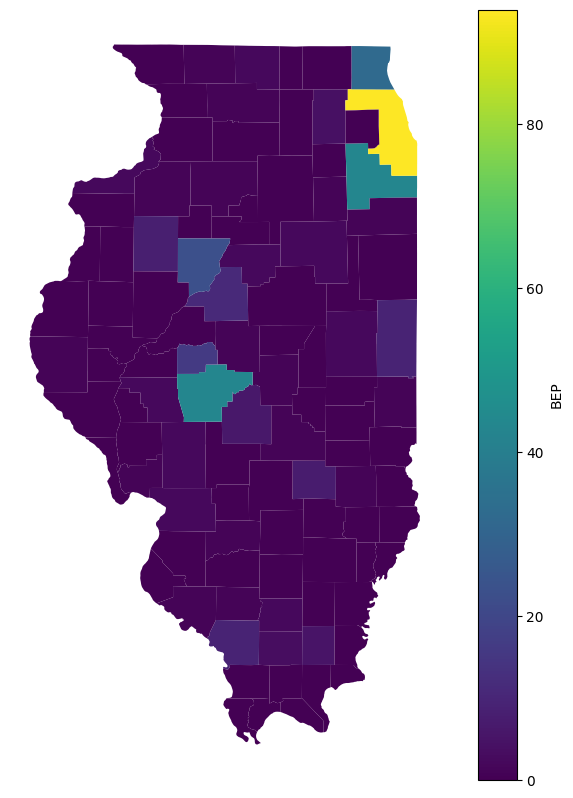

In [14]:
#then plot

fig, ax = plt.subplots(figsize=(10, 10))

shape_data_full.plot(ax = ax, column='Address',legend=True,figsize=(10,10), vmin = 0, vmax = 94, legend_kwds={'label': 'BEP'})
ax.set_axis_off()


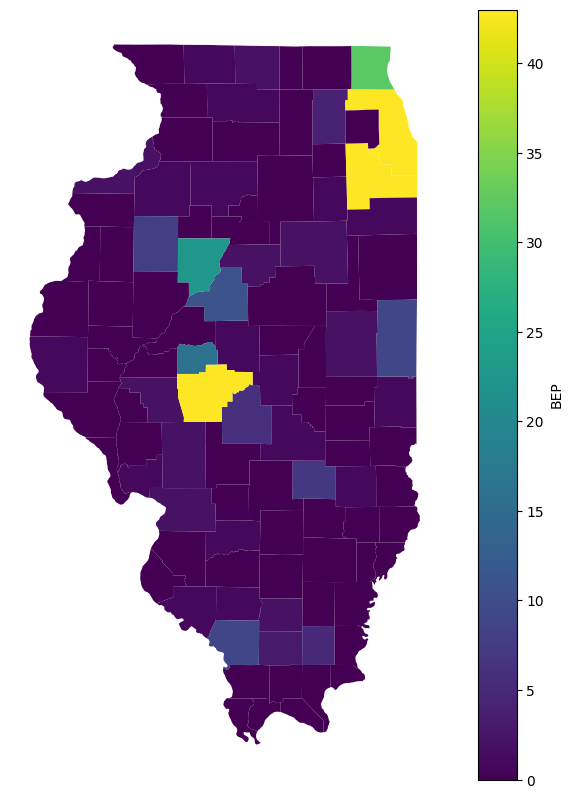

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

shape_data_full.plot(ax = ax, column='Address',legend=True,figsize=(10,10), vmin = 0, vmax = 43, legend_kwds={'label': 'BEP'})
ax.set_axis_off()


In [16]:
shape_data_full["Address"].max()

94.0

In [17]:
shape_data_full["Address"].min()

0.0

In [18]:
shape_data_full["Address"].describe()

count    109.000000
mean       3.532110
std       11.363985
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max       94.000000
Name: Address, dtype: float64

In [19]:
shape_data_full["Address"].nlargest()

53    94.0
38    43.0
58    43.0
75    32.0
86    23.0
Name: Address, dtype: float64